# Régression linéaire à variables multiples

<a name="toc_15456_1.1"></a>
## 1.1 Objectifs
- Étendre nos fonctions de régression pour supporter plusieurs caractéristiques
    - Étendre les structures de données pour supporter plusieurs caractéristiques
    - Réécrire les fonctions de prédiction, de coût et de gradient pour supporter plusieurs caractéristiques
    - Utiliser NumPy `np.dot` pour vectoriser leurs implémentations afin de les accélérer et de les simplifier.


<a name="toc_15456_1.2"></a>
## 1.2 Outils
Dans ce TP, nous allons utiliser : 
- NumPy, un package populaire pour le calcul scientifique
- Matplotlib, un package populaire pour la visualisation de données

In [2]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
np.set_printoptions(precision=2)  # réduit la précision d'affichage des tableaux numpy

<a name="toc_15456_1.3"></a>
## 1.3 Notation
Voici un résumé de certaines des notations que vous rencontrerez, mis à jour pour plusieurs caractéristiques.

Notation générale

| $a$ | scalaire, pas écrit en gras                                                      

| $\mathbf{a}$ | vecteur, écrit en gras                                                

| $\mathbf{A}$ | matrice, majuscule en gras                                         

| **Régression** |         |    |     |

|  $\mathbf{X}$ | matrice des exemples d'entraînement                  | `X_train` |

|  $\mathbf{y}$  | cibles des exemples d'entraînement                | `y_train`|

|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{ème}$ exemple d'entraînement | `X[i]`, `y[i]`|

| m | nombre d'exemples d'entraînement | `m`|

| n | nombre de caractéristiques dans chaque exemple | `n`|

|  $\mathbf{w}$  |  paramètre : poids,                       | `w`    |

|  $b$           |  paramètre : biais                                           | `b`    |     

| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | Le résultat de l'évaluation du modèle à $\mathbf{x^{(i)}}$ paramétré par $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` | 


<a name="toc_15456_2"></a>
# 2 Énoncé du problème

Vous utiliserez (encore) l'exemple de la prédiction du prix des logements. L'ensemble de données d'entraînement contient trois exemples avec quatre caractéristiques (taille, chambres, étages et âge) montrés dans le tableau ci-dessous. Notez que, contrairement aux TP précédents, la taille est en pieds carrés plutôt qu'en millier de pieds carrés. Cela pose un problème, que vous résoudrez dans le prochain TP !

| Taille (pieds carrés) | Nombre de chambres  | Nombre d'étages | Âge de la maison | Prix (milliers de dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

Vous allez construire un modèle de régression linéaire en utilisant ces valeurs afin de pouvoir ensuite prédire le prix pour d'autres maisons. Par exemple, une maison de 1200 pieds carrés, 3 chambres, 1 étage, 40 ans.  

Veuillez exécuter la cellule de code suivante pour créer vos variables `X_train` et `y_train`.

In [4]:
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

<a name="toc_15456_2.1"></a>
## 2.1 Matrice X contenant nos exemples
De manière similaire au tableau ci-dessus, les exemples sont stockés dans une matrice NumPy `X_train`. Chaque ligne de la matrice représente un exemple. Lorsque vous avez $m$ exemples d'entraînement ( $m = 3$  dans notre exemple), et qu'il y a $n$ caractéristiques (4 dans notre exemple), $\mathbf{X}$ est une matrice de dimensions ($m$, $n$) (m lignes, n colonnes).

In [5]:
# les données sont stockées dans des tableaux/matrices numpy
print(f"Forme de X : {X_train.shape}, Type de X :{type(X_train)})")
print(X_train)
print(f"Forme de y : {y_train.shape}, Type de y :{type(y_train)})")
print(y_train)

Forme de X : (3, 4), Type de X :<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
Forme de y : (3,), Type de y :<class 'numpy.ndarray'>)
[460 232 178]


<a name="toc_15456_2.2"></a>
## 2.2 Vecteur de paramètres w, b

* $\mathbf{w}$ est un vecteur avec $n$ éléments.
  - Chaque élément contient le paramètre associé à une caractéristique.
  - Dans notre ensemble de données, n est 4.
  - Nous le dessinons comme un vecteur colonne

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ est un paramètre scalaire.

Pour l'exemple, $\mathbf{w}$ et $b$ seront chargés avec des valeurs initiales sélectionnées qui sont proches de l'optimal. $\mathbf{w}$ est un vecteur NumPy 1-D.

In [6]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"Forme de w_init : {w_init.shape}, Type de b_init : {type(b_init)}")

Forme de w_init : (4,), Type de b_init : <class 'float'>


<a name="toc_15456_3"></a>
# 3 Prédiction du modèle avec plusieurs variables
La prédiction du modèle avec plusieurs variables est donnée par le modèle linéaire :

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
ou en notation vectorielle :
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
où $\cdot$ est un `produit scalaire` de vecteurs

Pour démontrer le produit scalaire, nous allons implémenter la prédiction en utilisant (1) et (2).

<a name="toc_15456_3.1"></a>
## 3.1 Prédiction unique élément par élément
Notre précédente prédiction multipliait une valeur de caractéristique par un paramètre et ajoutait un paramètre de biais. Une extension directe de notre précédente implémentation de la prédiction à plusieurs caractéristiques serait de mettre en œuvre (1) ci-dessus en utilisant une boucle sur chaque élément, en effectuant la multiplication avec son paramètre et ensuite en ajoutant le paramètre de biais à la fin.


In [7]:
def predict_single_loop(x, w, b): 
    """
    prédiction unique en utilisant la régression linéaire
    
    Args:
      x (ndarray): Forme (n,) exemple avec plusieurs caractéristiques
      w (ndarray): Forme (n,) paramètres du modèle    
      b (scalaire):  paramètre du modèle     
      
    Returns:
      p (scalaire):  prédiction
    """


In [8]:
# obtenir une ligne de nos données d'entraînement
x_vec = X_train[0,:]
print(f"Forme de x_vec {x_vec.shape}, valeur de x_vec : {x_vec}")

# faire une prédiction
f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"Forme de f_wb {f_wb.shape}, prédiction : {f_wb}")

Forme de x_vec (4,), valeur de x_vec : [2104    5    1   45]


AttributeError: 'NoneType' object has no attribute 'shape'

Si votre code `predict_single_loop` fonctionne correctement, alors vous devriez voir :

`Forme de x_vec (4,), valeur de x_vec : [2104 5 1 45] Forme de f_wb (), prédiction : 459.9999976194083`

Notez la forme de x_vec. C'est un vecteur NumPy 1-D avec 4 éléments, (4,). Le résultat, f_wb est un scalaire.

<a name="toc_15456_3.2"></a>
## 3.2 Prédiction unique, vecteur

Notons que l'équation (1) ci-dessus peut être implémentée en utilisant le produit scalaire comme dans (2) ci-dessus. Nous pouvons utiliser des opérations vectorielles pour accélérer les prédictions.

Rappelez-vous du TP Python/Numpy que NumPy `np.dot()`[[lien](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)] peut être utilisé pour effectuer un produit scalaire de vecteurs.

In [9]:
def predict(x, w, b): 
    """
    prédiction unique en utilisant la régression linéaire
    Args:
      x (ndarray): Forme (n,) exemple avec plusieurs caractéristiques
      w (ndarray): Forme (n,) paramètres du modèle   
      b (scalaire):             paramètre du modèle 
      
    Returns:
      p (scalaire):  prédiction
    """


In [10]:
# obtenir une ligne de nos données d'entraînement
x_vec = X_train[0,:]
print(f"Forme de x_vec {x_vec.shape}, valeur de x_vec : {x_vec}")

# faire une prédiction
f_wb = predict(x_vec,w_init, b_init)
print(f"Forme de f_wb {f_wb.shape}, prédiction : {f_wb}")

Forme de x_vec (4,), valeur de x_vec : [2104    5    1   45]


AttributeError: 'NoneType' object has no attribute 'shape'

Si votre fonction de prédiction fonctionne bien, alors vous devriez voir

`Forme de x_vec (4,), valeur de x_vec : [2104 5 1 45] Forme de f_wb (), prédiction : 459.9999976194083`

Les résultats et les formes sont les mêmes que dans la version précédente qui utilisait une boucle. À l'avenir, np.dot sera utilisé pour ces opérations. La prédiction est maintenant une seule instruction. La plupart des fonctions l'implémenteront directement plutôt que d'appeler une fonction de prédiction séparée.

<a name="toc_15456_4"></a>
# 4 Calculer le coût avec plusieurs variables
L'équation de la fonction de coût avec plusieurs variables $J(\mathbf{w},b)$ est :
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
où :
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 

Contrairement aux TPs précédents, $\mathbf{w}$ et $\mathbf{x}^{(i)}$ sont des vecteurs plutôt que des scalaires supportant plusieurs caractéristiques.

Ci-dessous se trouve une implémentation des équations (3) et (4). Notez que cela utilise un schéma standard pour ce cours où une boucle for itère sur tous les exemples m.

In [11]:
def compute_cost(X, y, w, b): 
    """
    calculer le coût
    Args:
      X (ndarray (m,n)): Données, m exemples avec n caractéristiques
      y (ndarray (m,)) : valeurs cibles
      w (ndarray (n,)) : paramètres du modèle  
      b (scalaire)     : paramètre du modèle
      
    Returns:
      cost (scalaire): coût
    """
    # vous avez déjà résolu cet exercice. 
    # utilisez np.dot() ici
    m = X.shape[0]
    cost = 0.0
    #écrivez le code restant
    
    return cost

In [12]:
# Calculer et afficher le coût en utilisant nos paramètres optimaux pré-choisis. 
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Coût à w optimal : {cost}')

Coût à w optimal : 0.0


**Résultat attendu** : Coût à w optimal : 1.5578904045996674e-12

<a name="toc_15456_5"></a>
# 5 Descente de gradient avec plusieurs variables
Descente de gradient pour plusieurs variables :

$$\begin{align*} \text{répéter}&\text{ jusqu'à convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{pour j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

où, n est le nombre de caractéristiques, les paramètres $w_j$,  $b$, sont mis à jour simultanément et où  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m est le nombre d'exemples d'entraînement dans l'ensemble de données

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ est la prédiction du modèle, tandis que $y^{(i)}$ est la valeur cible

<a name="toc_15456_5.1"></a>
## 5.1 Calculer le gradient avec plusieurs variables
Une implémentation pour calculer les équations (6) et (7) est donnée ci-dessous. Il existe de nombreuses façons de mettre ça en œuvre.
Dans cette version, il y a : 
- une boucle externe sur tous les exemples $m$. 
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ pour l'exemple peut être calculé directement et accumulé
    - dans une deuxième boucle sur toutes les caractéristiques n :
        - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ est calculé pour chaque $w_j$.

In [13]:
def compute_gradient(X, y, w, b): 
    """
    Calcule le gradient pour la régression linéaire 
    Args:
      X (ndarray (m,n)): Données, m exemples avec n caractéristiques
      y (ndarray (m,)) : valeurs cibles
      w (ndarray (n,)) : paramètres du modèle  
      b (scalaire)     : paramètre du modèle
      
    Returns:
      dj_dw (ndarray (n,)): Le gradient du coût par rapport aux paramètres w. 
      dj_db (scalaire):       Le gradient du coût par rapport au paramètre b. 
    """
    m,n = X.shape           #(nombre d'exemples, nombre de caractéristiques)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    #codez la partie restante ici; 
    #la solution de cet exercice est déjà disponible dans la solution de la semaine dernière
    # utilisez np.dot()
        
    return dj_db, dj_dw

In [14]:
#Calculer et afficher le gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db à w,b initial : {tmp_dj_db}')
print(f'dj_dw à w,b initial : \n {tmp_dj_dw}')

dj_db à w,b initial : 0.0
dj_dw à w,b initial : 
 [0. 0. 0. 0.]


**Résultat attendu :**
```
dj_db à w,b initial : -1.6739251122999121e-06
dj_dw à w,b initial :
    [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]   
```

<a name="toc_15456_5.2"></a>
## 5.2 Descente de gradient avec plusieurs variables
La routine ci-dessous met en œuvre l'équation (5) ci-dessus.

In [16]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Effectue la descente de gradient en batch pour apprendre w et b. Met à jour w et b en prenant 
    num_iters pas de gradient avec le taux d'apprentissage alpha
    
    Args:
      X (ndarray (m,n))   : Données, m exemples avec n caractéristiques
      y (ndarray (m,))    : valeurs cibles
      w_in (ndarray (n,)) : paramètres initiaux du modèle  
      b_in (scalaire)     : paramètre initial du modèle
      cost_function       : fonction pour calculer le coût
      gradient_function   : fonction pour calculer le gradient
      alpha (float)       : Taux d'apprentissage
      num_iters (int)     : nombre d'itérations pour exécuter la descente de gradient
      
    Returns:
      w (ndarray (n,)) : Valeurs mises à jour des paramètres 
      b (scalaire)     : Valeur mise à jour du paramètre 
      """
    
    # Un tableau pour stocker le coût J et les w à chaque itération principalement pour le graphique plus tard
    J_history = []
    w = copy.deepcopy(w_in)  #éviter de modifier le w global dans la fonction
    b = b_in
    
    for i in range(num_iters):

        # Calcule le gradient et met à jour les paramètres
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Met à jour les paramètres en utilisant w, b, alpha et le gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Sauvegarde le coût J à chaque itération
        if i<100000:      # prévenir l'épuisement des ressources 
            J_history.append( cost_function(X, y, w, b))

        # Imprime le coût à chaque intervalle 10 fois ou autant d'itérations si < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #retourne le w,b final et l'historique de J pour le graphique

Dans la cellule suivante, vous testerez l'implémentation.

In [17]:
# initialiser les paramètres
initial_w = np.zeros_like(w_init)
initial_b = 0.
# quelques paramètres de descente de gradient
iterations = 1000
alpha = 5.0e-7
# exécuter la descente de gradient 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w trouvés par descente de gradient : {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prédiction : {np.dot(X_train[i], w_final) + b_final:0.2f}, valeur cible : {y_train[i]}")

Iteration    0: Cost     0.00   
Iteration  100: Cost     0.00   
Iteration  200: Cost     0.00   
Iteration  300: Cost     0.00   
Iteration  400: Cost     0.00   
Iteration  500: Cost     0.00   
Iteration  600: Cost     0.00   
Iteration  700: Cost     0.00   
Iteration  800: Cost     0.00   
Iteration  900: Cost     0.00   
b,w trouvés par descente de gradient : 0.00,[0. 0. 0. 0.] 
prédiction : 0.00, valeur cible : 460
prédiction : 0.00, valeur cible : 232
prédiction : 0.00, valeur cible : 178


**Résultat attendu :**
```
b,w trouvés par descente de gradient : -0.00,[ 0.2 0. -0.01 -0.07]
prédiction : 426.19, valeur cible : 460
prédiction : 286.17, valeur cible : 232
prédiction : 171.47, valeur cible : 178
```

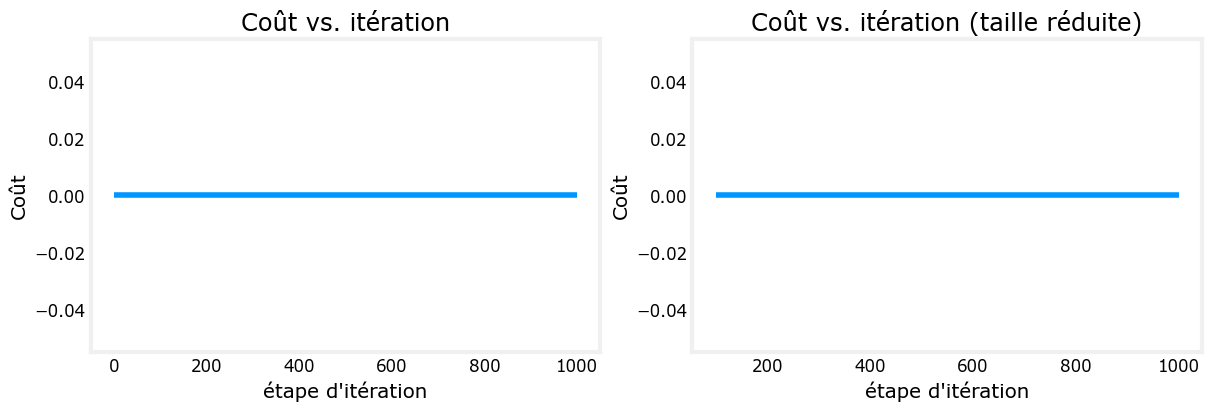

In [19]:
# tracer le coût par rapport à l'itération  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Coût vs. itération");  ax2.set_title("Coût vs. itération (taille réduite)")
ax1.set_ylabel('Coût')             ;  ax2.set_ylabel('Coût') 
ax1.set_xlabel('étape d\'itération')   ;  ax2.set_xlabel('étape d\'itération') 
plt.show()

*Ces résultats ne sont pas convaincants...* Le coût continue de diminuer et nos prédictions ne sont pas très précises. Le prochain TP explorera comment améliorer ça.

<a name="toc_15456_6"></a>
# 6 Félicitations !
Dans ce TP, vous avez :
- Réimplémenté les fonctions pour la régression linéaire, maintenant avec plusieurs variables.
- Utilisé NumPy `np.dot` pour vectoriser les implémentations